# Laboration maskininlärning AI21


In [2]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import numpy as np


## 1. Recommender system
### 1.1 - Movielens full - EDA

In [3]:
# Läs in dataset
movies = "Data/ml-latest/movies.csv"
ratings = "Data/ml-latest/ratings.csv"

df_movies = pd.read_csv(movies, usecols=["movieId", "title"], dtype={"movieId":"int32", "title":"str"})

df_ratings = pd.read_csv(ratings, usecols=["userId", "movieId", "rating"], dtype={"userId":"int32", "movieId":"int32", "rating":"float32"})

#### b) Vilka är de 10 filmerna med flest ratings?


In [4]:
# Beräkna antalet satta betyg per film
df_n_ratings = pd.DataFrame(df_ratings["movieId"].value_counts()).reset_index()
df_n_ratings.columns = ["movieId", "n_count"]
df_n_ratings.head(10)

,movieId,n_count
0,318,97999
1,356,97040
2,296,92406
3,593,87899
4,2571,84545
5,260,81815
6,480,76451
7,527,71516
8,110,68803
9,1,68469


#### c) Beräkna den genomsnittliga ratingen för dessa 10 filmerna med flest ratings.

In [5]:
# Tio filmerna med flest satta betyg
df_top_ten = pd.merge(df_n_ratings.head(10), df_movies, on="movieId")

top_ten_ratings = [(df_ratings.query("movieId == @id")["rating"].sum() / n ) for id, n in zip(df_top_ten["movieId"], df_top_ten["n_count"])]

df_top_ten["rating"] = top_ten_ratings

df_top_ten

,movieId,n_count,title,rating
0,318,97999,"Shawshank Redemption, The (1994)",4.424188
1,356,97040,Forrest Gump (1994),4.056585
2,296,92406,Pulp Fiction (1994),4.173971
3,593,87899,"Silence of the Lambs, The (1991)",4.151412
4,2571,84545,"Matrix, The (1999)",4.149695
5,260,81815,Star Wars: Episode IV - A New Hope (1977),4.120455
6,480,76451,Jurassic Park (1993),3.665034
7,527,71516,Schindler's List (1993),4.257502
8,110,68803,Braveheart (1995),4.008481
9,1,68469,Toy Story (1995),3.886649


#### d) Gör en plot över årtal och antalet filmer representerade i datasettet.


In [6]:
df_movies["year"] = df_movies["title"].str.extract('(\(\d{4}\))')[0].str[-5:-1].astype("Int16")
df_movies

,movieId,title,year
0,1,Toy Story (1995),1995
1,2,Jumanji (1995),1995
2,3,Grumpier Old Men (1995),1995
3,4,Waiting to Exhale (1995),1995
4,5,Father of the Bride Part II (1995),1995
...,...,...,...
58093,193876,The Great Glinka (1946),1946
58094,193878,Les tribulations d'une caissière (2011),2011
58095,193880,Her Name Was Mumu (2016),2016
58096,193882,Flora (2017),2017


In [7]:
years_describe = df_movies["year"].describe()
bins = int(years_describe[7]-years_describe[3]+1)
bins

145

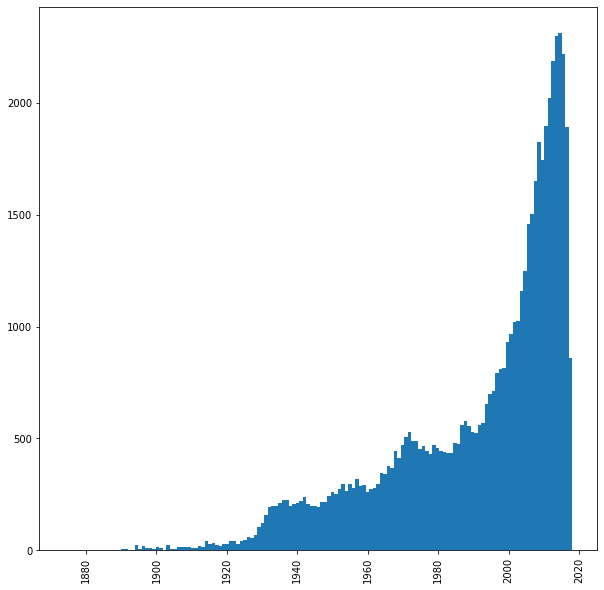

In [8]:
plt.figure(figsize = [10, 10])
plt.hist(x = df_movies["year"].dropna(), bins=bins)

plt.xticks(rotation=90);

##### e) Gör en plot över antalet ratings mot movieId.


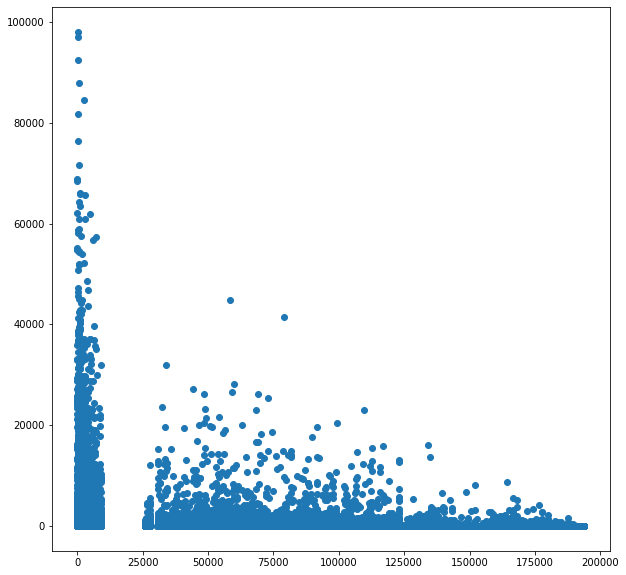

In [9]:
plt.figure(figsize = [10, 10])
plt.scatter("movieId", "n_count", data= df_n_ratings);

####  Beräkna genomsnittliga ratings för de top 10 filmerna med flest ratings. Gör ett stapeldiagram över dessa.

Text(0.5, 0, 'Rating')

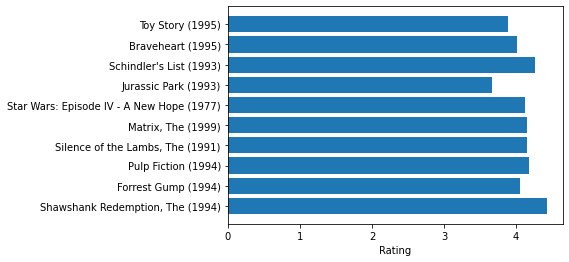

In [10]:
plt.barh(df_top_ten["title"], df_top_ten["rating"] )

plt.xlabel("Rating")

### 1.2 Skapa gles matris
##### Rensa data

- Jag behöver inte rensa några data för att kunna köra programmet utan bara för att förbättra modellen.
- Tänkte ta bort filmer som fått få totalt antal röster. Om de fått få röster kan de inte ge så mycket information om andra filmer. Men då kan man ju inte söka på de filmerna och det var ju trist. Så jag behöll dem. De får ändå ganska bra resultat.
- Däremot tar jag bort de användare som röstat på väldigt få filmer då de inte tillför så mycket information mellan filmer. Vad som är en lämplig gräns skulle behöva provas ut.

In [119]:
# Ta bort användare som gett få röster
user_n_of_ratings = df_ratings.userId.value_counts()
users_to_ceep = user_n_of_ratings[user_n_of_ratings > 5].index
df_ratings[df_ratings[ "userId"].isin(users_to_ceep)]
df_ratings_cleaned = df_ratings[df_ratings[ "userId"].isin(users_to_ceep)]
df_ratings_cleaned.shape

(27678678, 3)

##### Skapa den glesa matrisen
Hur han gjorde det här i videon var ju helt 🤯 Indexen blev ju 🤪🤦

På det här sättet blir 
- raderna == movieId 
- kolonnerna == userId

Samt att det går att köra utan att rensa några data.

In [120]:
mat_movies_users = csr_matrix((df_ratings_cleaned.rating, (df_ratings_cleaned.movieId, df_ratings_cleaned.userId))) 

type(mat_movies_users), mat_movies_users.shape

(scipy.sparse._csr.csr_matrix, (193887, 283229))

### 1.3 Rekommenderarsystemet

 Det han gör i videon är helt felaktigt och han söker inte på den film han matar in, pga felaktiga index. 

 Den här modellen ger ganska bra rekomendationer ändå. Se några exempel nedan. 
 - "Live and Let Die" gav bara andra Bond-filmer som ligger nära i tid till exempel

Hur fungerar det:
- Först läser man in och rensar datan.
- Sen skapar man en glesmatris med filmtitlar mot användare.
- Matrisen annvänds för att träna en närmast grannar-modell.

- Användaren anger en filmtitel.
- Med fuzzywuzzy hittar man en matchande filmtitel i datan och tar fram movieId
- med k närmast grannar hittar man de n filmer som ligger närmast i vinkel mot den angivna filmen
    - Det som knn gör är att den tar filmen som en vektor med alla användare som dimensioner och respektive betyg som värden.
    - Sen jämför den denna vektor med alla andra filmvektorer och ser vilka som har minst vinkel mot angivna sökfilmen.
    - Dessa har alltså fått liknande betyg av samma användare som sökfilmen. Så kanske är de då liknande.
    - Detta ger movieId för de n bästa matchningarna 
   
- Med movieId tas namnet på filmerna fram och skrivs ut.


In [121]:
# Rekomenderare
def recommender(movie_name, data, model, n_recomendations):
    # Plockar fram index i df_movies för den film som best matchar söktermen
    idx_m = process.extractOne(movie_name, df_movies.title)[2]
    # Ta fram movieid för filmen med det indexet
    movieid = df_movies.loc[idx_m,"movieId"]
 
    print("Movie Selected: ", df_movies["title"][idx_m])
    print("Searching for recommendations ... ")
    
    # Välj de filmer med minst vinkel till den angivna filmen
    _, indices = model.kneighbors(data[movieid], n_neighbors=n_recomendations+1)
    
    # Skriv ut de föreslagna filmerna (utelämna den första som givetvis är den angivna)
    for i in indices[0][1:]:
        print(df_movies.query("movieId == @i").iloc[0]["title"])
    

In [122]:
# Modell
model_knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=20) 
model_knn.fit(mat_movies_users)                                                 

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [131]:
recommender("North by Northwest", mat_movies_users, model_knn, 5)

Movie Selected:  North by Northwest (1959)
Searching for recommendations ... 
Rear Window (1954)
Vertigo (1958)
Citizen Kane (1941)
Casablanca (1942)
Chinatown (1974)


In [ ]:
recommender("Escape from Alcatraz", mat_movies_users, model_knn, 5)

Movie Selected:  Escape from Alcatraz (1979)
Searching for recommendations ... 
Dirty Harry (1971)
Papillon (1973)
For a Few Dollars More (Per qualche dollaro in più) (1965)
Bullitt (1968)
Scarface (1983)


In [124]:
recommender("Live and let die", mat_movies_users, model_knn, 5)

Movie Selected:  Live and Let Die (1973)
Searching for recommendations ... 
For Your Eyes Only (1981)
Thunderball (1965)
Man with the Golden Gun, The (1974)
Spy Who Loved Me, The (1977)
Diamonds Are Forever (1971)


In [125]:
recommender("Gaslight", mat_movies_users, model_knn, 5)

Movie Selected:  Gaslight (1944)
Searching for recommendations ... 
Spellbound (1945)
Suspicion (1941)
Laura (1944)
Rebecca (1940)
Notorious (1946)


In [127]:
recommender("Terminator 2", mat_movies_users, model_knn, 5)

Movie Selected:  Terminator 2: Judgment Day (1991)
Searching for recommendations ... 
Jurassic Park (1993)
Terminator, The (1984)
Speed (1994)
Fugitive, The (1993)
Braveheart (1995)


In [128]:
recommender("American Graffiti", mat_movies_users, model_knn, 5)

Movie Selected:  American Graffiti (1973)
Searching for recommendations ... 
Animal House (1978)
Close Encounters of the Third Kind (1977)
Blazing Saddles (1974)
Bull Durham (1988)
Dog Day Afternoon (1975)
